# Bayesian update: Beta and Bernoulli

Federico Cerutti
[federico.cerutti@unibs.it](mailto:federico.cerutti@unibs.it)


Material distributed under CC-BY.

In [0]:
# vilualise graphs in the notebook itself
%matplotlib inline

# libs for manipulating random variables
from scipy.stats import bernoulli,beta

# libs for plotting graphs
import matplotlib.pylab as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.lines import Line2D

## Generator of aleatoric uncertainty

**Modify the parameter in the following cell for different experiments**

In [0]:
# parameter for our Bernoulli
#mu = 0.5 # fair coin
mu = 0.2 # weighted coin

In [0]:
# let's generate 1000 iid samples --- let's toss the coin 200 times
 observations = bernoulli.rvs(mu, size=200)

In [0]:
observations

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

# Frequentist paradigm

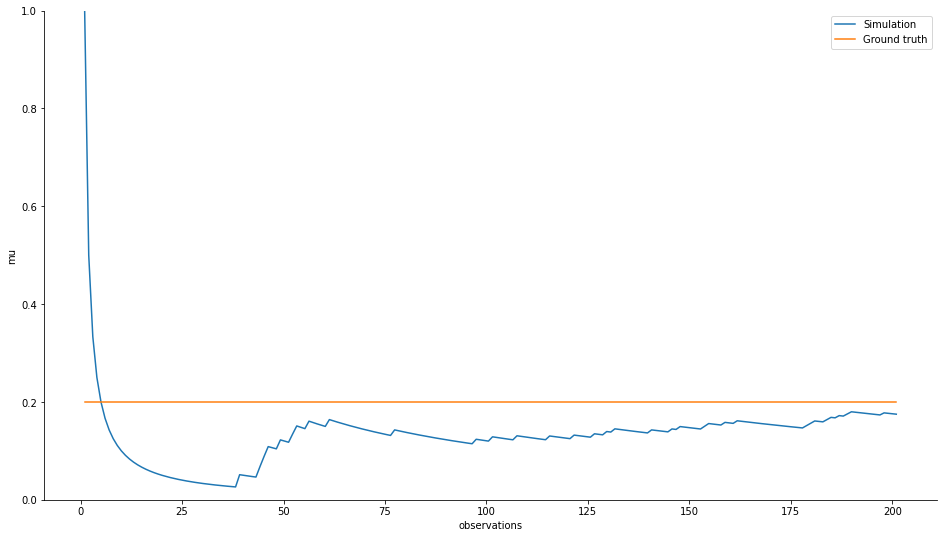

In [0]:
# let's simulate the overfit problem of frequentist paradigm and rememeber: the more the data, the less the overfit
estimated_mu = []
cumulative_mu = 0
data = np.linspace(1, len(observations)+1, len(observations))
for idx,val in enumerate(observations):
    cumulative_mu += val
    estimated_mu.append(float(cumulative_mu) / float(idx + 1))

fig, ax = plt.subplots(figsize=(16,9))
plt.plot(data, estimated_mu, label="Simulation")
plt.plot(data, np.full(data.shape, mu), label="Ground truth")

# prettier graph, nothing else
plt.ylim(0, 1)
ax.legend()
ax.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('mu')
ax.set_xlabel('observations')
plt.show()

## Bayesian paradigm

In [0]:
import warnings
warnings.filterwarnings('ignore')

# rect function: 1 if l <= x <= r, 0 otherwise
def rect(x, l, r):
    return np.where((x < l) | (x > r), 0, 1)

# compute the line draws and the statistics of the distribution
def beta_data(a, b, betaplot = None):
    if not isinstance(a, float):
        a = float(a)
    if not isinstance(b, float):
        b = float(b)

    xs = np.linspace(0,1,10000)
    
    if betaplot is None:
        betaplot = Line2D([],[])
    
    betaplot.set_data(xs, beta.pdf(xs, a,b))
    # let's compute the interval that contains 95% of the probability masses
    x1, x2 = beta.interval(0.95, a, b)
    areaplot = np.multiply(beta.pdf(xs, a,b), rect(xs,x1, x2))
    
    return xs, betaplot, areaplot


# function to print info and graph of Beta distribution
def beta_info(a, b, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(16,9))

    xs, betaplot, areaplot = beta_data(a, b)
    ax.add_line(betaplot)
    ax.fill_between(xs, 0, areaplot, alpha=0.5)
    beta_text = "Beta(%.2f,%.2f)\nMean: %.02f\nVariance: %.2f" % (a, b, beta.mean(a,b), beta.var(a,b))
    ax.text(0.8*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], beta_text)

    #prettier graph
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

**Modify the parameters in the following cell for different experiments**

In [0]:
# Let's set our prior
#a, b = (0.5, 0.5) # Jeffreys uninformative prior
a, b = (1.0, 1.0) # Uniform prior

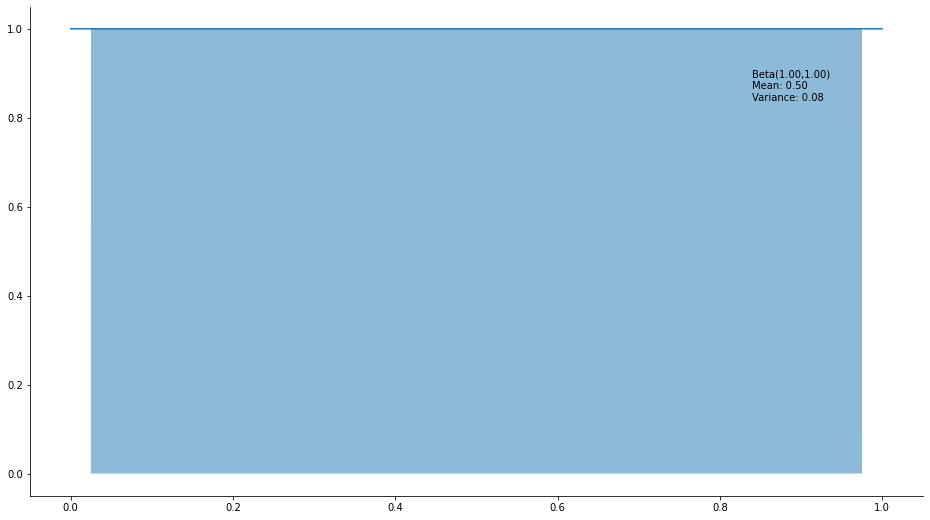

In [0]:
# let's plot and print out the characteristics of our beta
beta_info(a,b)

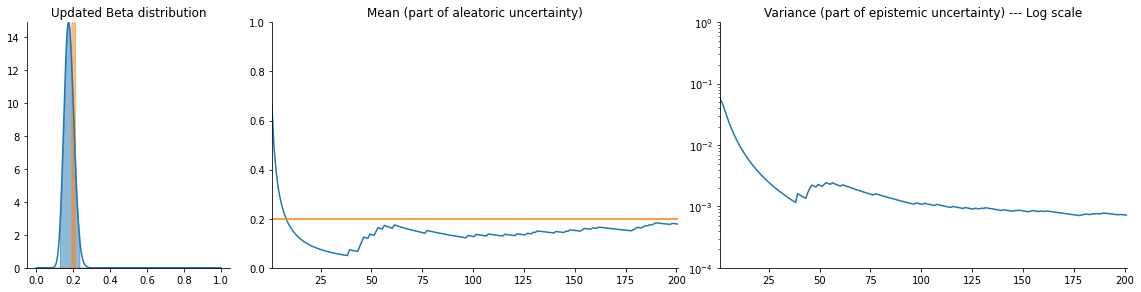

In [0]:
# Let's run Bayesian update
# Based upon https://matplotlib.org/gallery/animation/subplots.html 
class BayesianUpdate(animation.TimedAnimation):
    def __init__(self, prior, observations, ground_truth):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4), gridspec_kw={'width_ratios': [1, 2, 2]})
        fig.tight_layout()
        self.estimated_beta = [prior]
        self.observations = observations
        self.data = np.linspace(1, len(self.observations)+1, len(self.observations))
        self.means = np.full(self.data.shape, np.nan)
        self.variances = np.full(self.data.shape, np.nan)
        self.ground_truth = ground_truth

        self.betaplot = Line2D([],[])
        axes[0].add_line(self.betaplot)
        axes[0].set_title('Updated Beta distribution')
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['top'].set_visible(False)


        axes[1].set_xlim((data[0], data[-1]))
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)
        axes[1].set_ylim((0,1))
        self.meansplot = Line2D([],[])
        axes[1].add_line(self.meansplot)
        axes[1].plot(self.data, np.full(self.data.shape, self.ground_truth), color='C1')
        axes[1].set_title('Mean (part of aleatoric uncertainty)')


        axes[2].set_xlim((data[0], data[-1]))
        axes[2].spines['right'].set_visible(False)
        axes[2].spines['top'].set_visible(False)
        axes[2].set_yscale('log')
        axes[2].set_ylim((1e-4,1.0))
        self.variancesplot = Line2D([],[])
        axes[2].add_line(self.variancesplot)
        axes[2].set_title('Variance (part of epistemic uncertainty) --- Log scale')

        animation.TimedAnimation.__init__(self, fig, interval=200, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        new_a, new_b = self.estimated_beta[-1]
        val = self.observations[i]
        if val == 1:
            new_a += 1
        else:
            new_b += 1
        self.estimated_beta.append((new_a, new_b))
        
        xs, _, areaplot = beta_data(new_a, new_b, self.betaplot)
        maxybetaplot = np.nan
        try:
            maxybetaplot = np.max(self.betaplot.get_ydata())
            self.betaplot.axes.set_ylim((0, maxybetaplot))
        except:
            maxybetaplot = 100

        self.betaplot.axes.collections.clear()
        self.betaplot.axes.fill_between(xs, 0, areaplot, alpha=0.5, color='C0')
        self.betaplot.axes.fill_between(xs, 0, maxybetaplot * rect(xs, self.ground_truth-1e-2, self.ground_truth+1e-2), alpha=0.5, color='C1')

        self.means[i] = beta.mean(new_a,new_b)
        self.variances[i] = beta.var(new_a,new_b)
        self.meansplot.set_data(self.data, self.means)
        self.variancesplot.set_data(self.data, self.variances)

    def new_frame_seq(self):
        return iter(range(len(observations)))

    def _init_draw(self):
        lines = [self.betaplot, self.meansplot, self.variancesplot]
        for l in lines:
            l.set_data([], [])



HTML(BayesianUpdate(prior=(a,b), observations=observations, ground_truth=mu).to_html5_video())

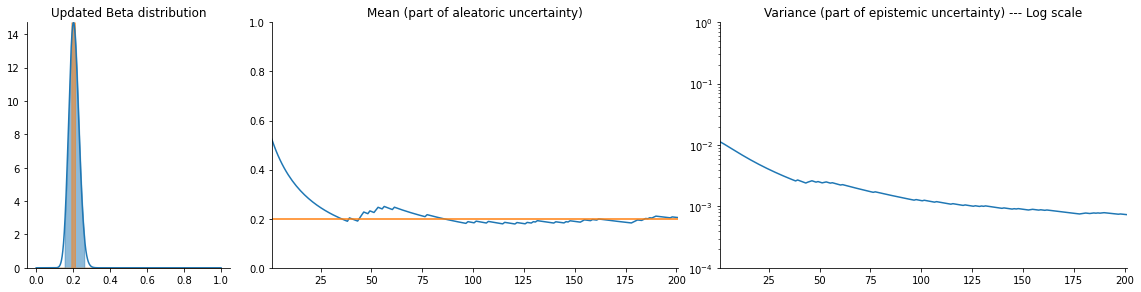

In [0]:
# Heavy prior that the coin is fair
HTML(BayesianUpdate(prior=(10,10), observations=observations, ground_truth=mu).to_html5_video())